## Predicting West Nile Virus
#### Listed here are the processed & modeled data


In [2]:
#things to note:
# k_fold cross validation & train test split 
# grid searched over multiple models, a bit of a shotguned method
# auc/roc curve evaluation
# final Kaggle submission

In [17]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
init_data = pd.read_csv('./input/train.csv',parse_dates=['Date'])

Looking at the inital data, we can see it is rather clean and organized

In [7]:
init_data.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [15]:
init_data.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object

In [8]:
print('Checking the amount of null values:')
init_data.isnull().sum()

Checking the amount of null values:


Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [11]:
profile = pandas_profiling.ProfileReport(init_data)

In [12]:
profile

Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,5
Categorical,5
Boolean,1
Date,1
Text (Unique),0
Rejected,0


x indicates WNV, red indicates mosquito density


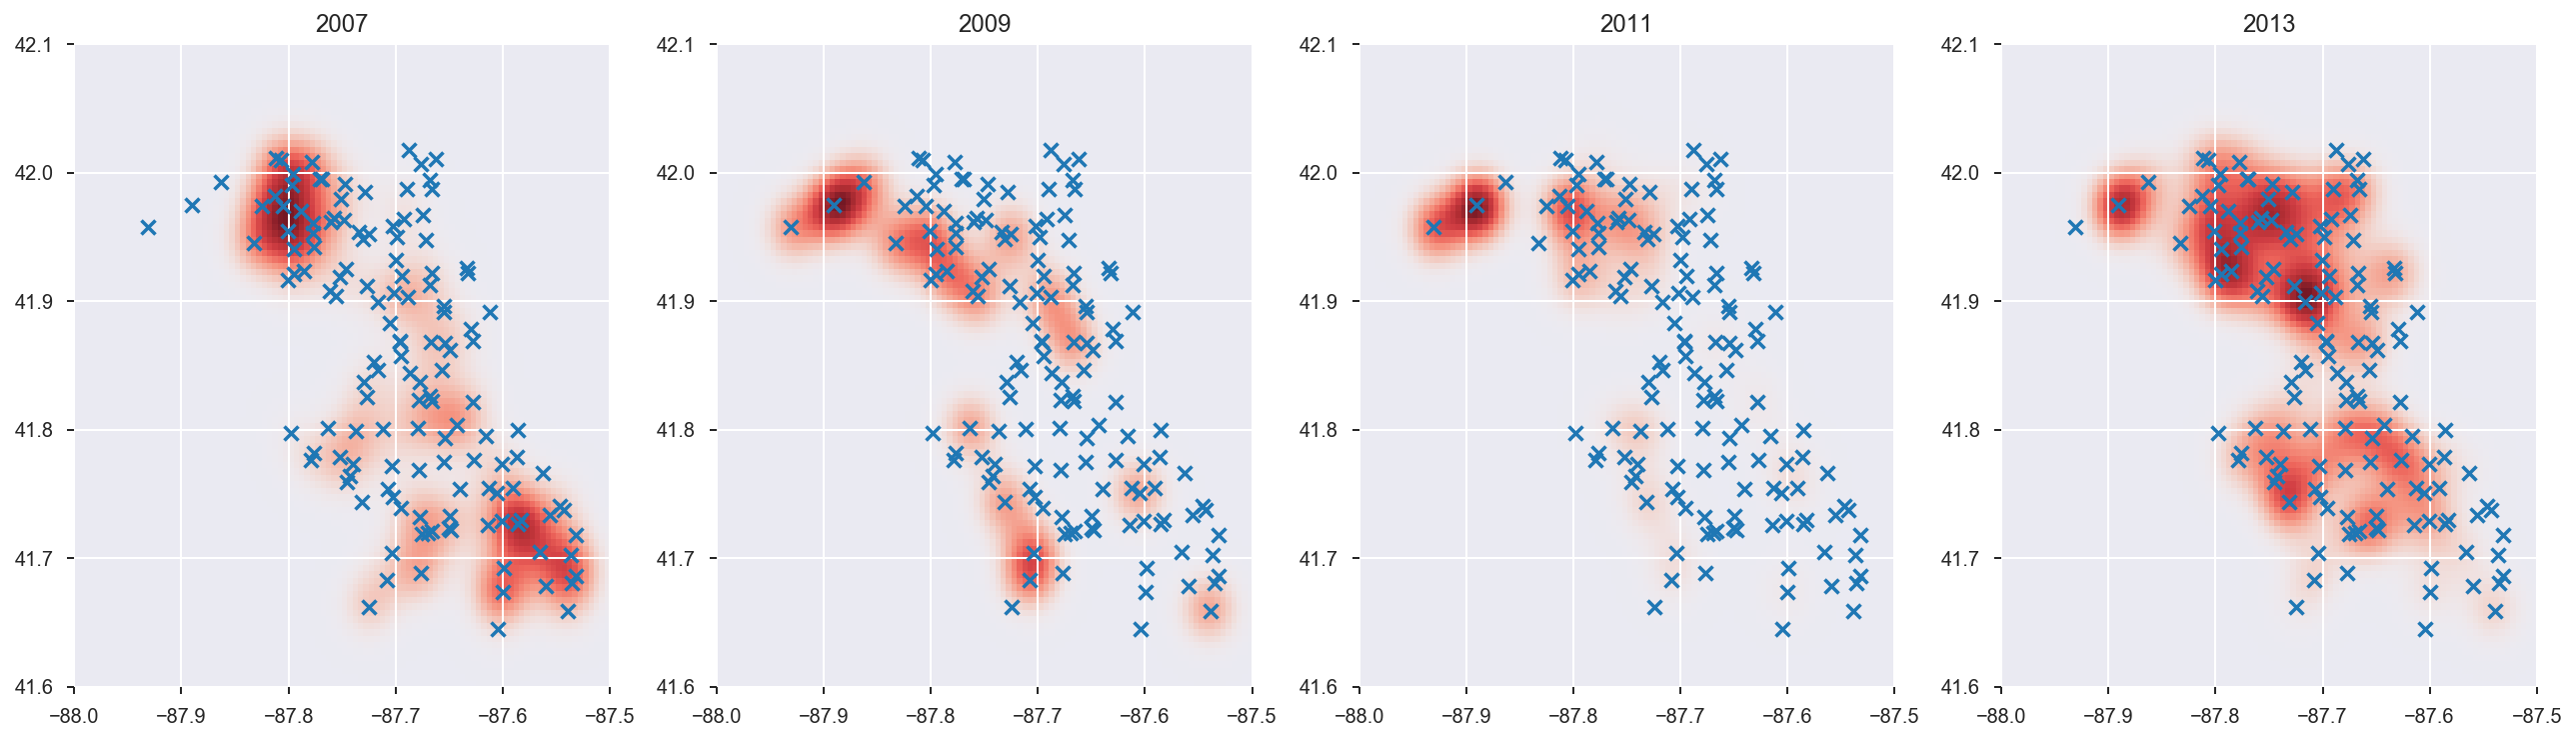

In [19]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = 1.2
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(18,6))
for year, subplot in zip([2007, 2009, 2011, 2013], [141, 142, 143, 144]):
    sightings = init_data[(init_data['WnvPresent'] > 0) & (init_data['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)

    plt.imshow(zv,
               origin='lower',
               cmap=alpha_cm,
               extent=lon_lat_box,
               aspect=aspect)
    plt.tight_layout()
    locations = init_data[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x')
#print('WNV presence vs mosquito density over time')
print('x indicates WNV, red indicates mosquito density')

In [24]:
init_data.Species.groupby(init_data.WnvPresent).value_counts()

WnvPresent  Species               
0           CULEX PIPIENS/RESTUANS    4490
            CULEX RESTUANS            2691
            CULEX PIPIENS             2459
            CULEX TERRITANS            222
            CULEX SALINARIUS            86
            CULEX TARSALIS               6
            CULEX ERRATICUS              1
1           CULEX PIPIENS/RESTUANS     262
            CULEX PIPIENS              240
            CULEX RESTUANS              49
Name: Species, dtype: int64

- It would seem only 3 species have carried WNV
- This would be an interesting direction to study with bayesian analysis and/or monte carlo simulations

# Preprocessing

In [2]:
%run -i ProcessPipeline.py

In [3]:
%%time

FullTrain = pd.read_csv('./input/train.csv')
Ftest = pd.read_csv('./input/test.csv', index_col= 0)

FullTrain , Ftestpp = ProcessPipeline(FullTrain,Ftest)

0 (116293, 10)
1 (116293, 13)
3 (116293, 21)
2 (116293, 38)
CPU times: user 7min 13s, sys: 5.45 s, total: 7min 18s
Wall time: 7min 27s


# Model Generation

In [4]:
#Full Train is the data which we will use to improve our model and make predictions based on...
FullTrain.to_csv('Pro_Train.csv', index = False)

#make predictions based on the inputs from the Kaggle data, aka. Ftest2
Ftestpp.to_csv('Pro_Test.csv', index = False)
Ftest2 = Ftestpp.drop(['Date','Species','Trap','Location'], axis = 'columns')

In [5]:
FullTrain.columns

Index(['NumMosquitos', 'WnvPresent', 'Date', 'Species', 'Trap', 'Latitude',
       'Longitude', 'Location', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TERRITANS',
       'CULEX TARSALIS', 'CULEX ERRATICUS', 'W0', 'W1', 'W2', 'W3', 'P0', 'P1',
       'P2', 'P3', 'DewPointamax', 'DewPointamin', 'DewPointmean',
       'StnPressureamax', 'StnPressureamin', 'StnPressuremean', 'AvgSpeedamax',
       'AvgSpeedamin', 'AvgSpeedmean', 'Tmaxamax', 'Tminamin', 'Tavgmean',
       'PrecipTotalsum', 'PrecipTotalmean', 'temp_expected', 'temp_diff',
       'sunset'],
      dtype='object')

In [ ]:
#adding one-hot-encoded values...
Traps = pd.get_dummies(df.Trap)
df.join(Traps)

In [7]:
target = FullTrain['WnvPresent']
toDrop = ['Date', 'WnvPresent','Location','NumMosquitos','Species',
          'Trap']

#This is currently redundant, because the data is later kfold crossvalidated...
X = FullTrain.drop(toDrop, axis = 'columns')
X_train0, X_test0, y_train, y_test = train_test_split(X, target, test_size = .2)


#scaled the values to range from 0-1 due to the impact of highly variable values 
#(eg. height can be measured in cm, and thus vary by the hundreds, while temp can only vary by a few degrees)
ss = StandardScaler()
X_train = ss.fit_transform(X_train0)
X_test = ss.transform(X_test0)
Xss = ss.fit_transform(X)
Ftest2 = ss.transform(Ftest2)

In [25]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV


def best_model(model_list, X_train, y_train):
    """
    Runs a randomized search of 10 iters, and strat-kfold cv
    And produces a list of classifiers - parameters - scores
    for the best of each type of model
    
    To change it to ONLY spit out the best model, replace 
    
    'return classifier' 
    
    for
    
    'return best_classifier[1]'
    """
    best_score = 0.0
    best_classifier = None
    classifiers = []
    for name, model, parameters in model_list:
        classifiers.append(best_config(name, model, parameters,
                                       X_train,
                                       y_train))
 
    for name, score, classifier in classifiers:
        if (score > best_score):
            best_score = score
            best_classifier = [name, classifier]
    return classifiers

def best_config(name, model, parameters, X_train, y_train):
    """
    A simple GridSearch 
    Requires: model, parameters, X & y variables
    """
    print("Searching "+str(name))
    clf = RandomizedSearchCV(model, parameters[0], 
                             scoring='roc_auc', cv=StratifiedKFold(n_splits=4), 
                            n_iter=80, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Finished "+str(name))
    print('')
    return [str(clf.best_params_), 
            clf.best_score_, 
            clf.best_estimator_]

def model_list():
    
    """
    Generates a list of models & params,
    Add more manually, for more options
    gb = GradientBoostingClassifier()
    rf = RandomForestClassifier()
    bg = BaggingClassifier()
    ad = AdaBoostClassifier()
    knn = KNeighborsClassifier()
    """
    models = []    

    
    #gradient
    gb_tuned_parameters = [{"n_estimators": [x for x in range(100, 400, 2)],
                            'min_samples_split' : [2, 3, 4]}]
    models.append(['GB', GradientBoostingClassifier(n_jobs=-1), gb_tuned_parameters])
 
    #random forest
    rf_tuned_parameters = [{'n_estimators' : [x for x in range(100, 400, 2)],
                            'min_samples_split' : [2, 3, 4]}]
    models.append(["RandomForest",RandomForestClassifier(n_jobs=-1),rf_tuned_parameters])

    #Bagged
    bg_tuned_parameters = [{"n_estimators": [x for x in range(100, 400, 2)]}]
    models.append(['BG', BaggingClassifier(n_jobs=-1), bg_tuned_parameters])

    #Ada Model
    ad_tuned_parameters = [{"n_estimators": [x for x in range(100, 400, 2)]}]
    models.append(['AD', AdaBoostClassifier(n_jobs=-1), ad_tuned_parameters])
    
    """
    #kNN Model
    knn_tuned_parameters = [{"n_neighbors": [1, 3, 5, 10, 20], 
                             'weights':['uniform','distance'],
                            'metric':['euclidean','manhattan']}]
    models.append(["kNN", KNeighborsClassifier(),knn_tuned_parameters])
    """
    
    return models

In [26]:
GS_model = best_model(model_list(),X_train,y_train)

Searching GB
Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 320 out of 320 | elapsed:  9.0min finished


Finished GB

Searching RandomForest
Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 320 out of 320 | elapsed:  8.1min finished


Finished RandomForest

Searching BG
Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 19.4min
[Parallel(n_jobs=2)]: Done 320 out of 320 | elapsed: 31.7min finished


Finished BG

Searching AD
Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 320 out of 320 | elapsed:  8.6min finished


Finished AD



- Well the bagging classifier took some time, but that is not much of a surprise.

# Model Evaluations

In [33]:
#generates the best of each classifier & their scores
GS_model

[["{'n_estimators': 114, 'min_samples_split': 2}",
  0.8478194965881999,
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=114,
                presort='auto', random_state=None, subsample=1.0, verbose=0,
                warm_start=False)],
 ["{'n_estimators': 232, 'min_samples_split': 4}",
  0.8219278383711053,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=232, n_jobs=-1,
              oob_sco

In [34]:
#selects the model from the dict-grid search
best_model = GS_model[0][2]

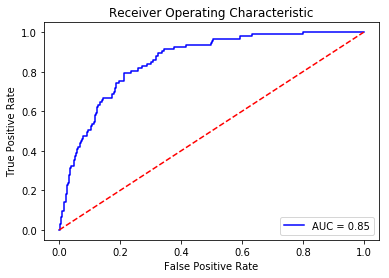

In [35]:
best_model.fit(X_train, y_train)
best_model.score(X_test,y_test)
probs = best_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# predictions for Kaggle

In [37]:
predProb = best_model.predict_proba(Ftest2)[:,1]

In [40]:
dfs = pd.DataFrame(predProb)
dfs.columns = ['WnvPresent']
dfs['Id'] = range(1,len(dfs)+1)
dfs.index = range(1, len(dfs)+1)
dfs = dfs[['Id','WnvPresent']]
dfs.to_csv('preds3.csv', index = False)

In [ ]:
predProb = bg.predict_proba()